In [7]:
from typing_extensions import TypedDict, Annotated
from langgraph.graph import add_messages,StateGraph, START, END  
from initializeLLM import get_openai_llm
from dotenv import load_dotenv
load_dotenv()

llm = get_openai_llm()

class State(TypedDict):
    messages: Annotated[list, add_messages]


def chat_bot(state:State):
    response = llm.invoke(state['messages'])
    return {"messages": response}


In [8]:
graph = StateGraph(State)
graph.add_node('chat', chat_bot)
graph.add_edge(START, 'chat')
graph.add_edge('chat', END)
app = graph.compile()

try:
    result = app.invoke({"messages": ["Hello, who are you?"]})
    print(result)
except Exception as e:
    print("Error Block...",e)

{'messages': [HumanMessage(content='Hello, who are you?', additional_kwargs={}, response_metadata={}, id='cb0b6a4a-4874-44e1-abac-409443f97cf4'), AIMessage(content='Hello! I’m an AI developed by OpenAI, here to help you with information, answer questions, and assist with a variety of topics. What can I do for you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 13, 'total_tokens': 50, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CCHZQQwpOR0OpavXp9eNxyedBaZV4', 'finish_reason': 'stop', 'logprobs': None}, id='run-b92ac9e8-e3a2-4c32-b39c-693af4ca9de6-0', usage_metadata={'input_tokens': 13, 'output_tokens': 37, 'total_tokens': 50, 'input_token_details': {'audio': 0,

In [20]:
def see_graph(app):
    from IPython.display import display, Image
    image = Image(app.get_graph().draw_mermaid_png())
    display(image)

In [40]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_tavily import TavilySearch


@tool
def tavily_search(query:str) -> str:
    """
    Use this tool to search the web for recent information.
    Input: A search query string.
    Output: A string containing the search results.
    """
    
    tool = TavilySearch(
            max_results=5,
            topic="general",
            search_depth="advanced"
        )
    response = tool.invoke(query)
    return response

@tool
def llm_search(query) -> str:
    """Use this tool for LLM based search not for recent information and news."""
    response = llm.invoke(query)
    return response

In [41]:
tools = [tavily_search,llm_search]
llm_with_tools = llm.bind_tools(tools)
def chat_bot(state:State):
    response = llm_with_tools.invoke(state['messages'])
    return {"messages": response}

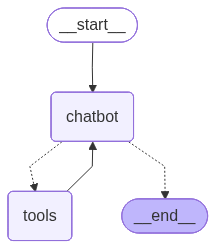

In [ ]:
from langgraph.checkpoint.memory import MemorySaver 
memory = MemorySaver(max_memory=5)

tools_node = ToolNode(tools) 
graph = StateGraph(State)
graph.add_node('chatbot', chat_bot)
graph.add_node('tools', tools_node)
graph.add_conditional_edges('chatbot', tools_condition)
graph.add_edge("tools", 'chatbot')
graph.set_entry_point('chatbot')
app = graph.compile(checkpointer=memory)
see_graph(app)

In [50]:
# app.invoke({"messages": ["Who is the captain of the Indian cricket team?"]})
config = {"configurable":{"thread_id": 1}}
query = "What all questions I had asked you until now on thread 1?"
result = app.invoke({"messages": [query]},config=config)
print(result['messages'][-1].content)

I'm unable to access the specific questions you've asked in previous threads or sessions. However, if you have any questions or topics you'd like to discuss now, feel free to ask!
